Author: Adrian Swartz<br>
Date: 3/29/2019


# Solutions to Andew Ng's coursera problems
## Example 1: Simple Linear Regression

Andrew Ng's course is designed for the solutions to be worked through in Octave (similar to matlab). However, I am going to do these problems in python (within a jupyter notebook) and demonstrate how various approaches can be implemented in python.

This notebook is structured as follows:<br>
[Part 1 - Linear Regression With One Variable](#Part1)
1. [Exploratory Data Analysis](#eda)
2. [Linear Regression By Gradient Descent](#gd)<br>
    2a. [Visualizing the Cost Function](#viz)<br>
    2b. [Learning About Learning Rates](#lr)
3. [Linear Regression By The Normal Equation](#ne)
4. [Linear Regression with sklearn](#sk)
5. [Quick Regression Visualizations With Searborn's regplot](#sns)

[Part 2 - Multivariate Linear Regression](#Part2)
1. [Exploratory Data Analysis](#eda2)
2. [Feature Normalization](#FN)
3. [Implementing Gradient Descent](#gd2)
4. [Multivariate Linear Regression By The Normal Equation](#ne2)
5. [Multivariate Linear Regression with sklearn](#sk2)

***

For this exercise, we will import several python packages: NumPy (numerical python for matrix manupulations and advanced math), pandas (DataFrames offer a useful platform for importing data and performing exploratory data analysis), matplotlib and seaborn for data visualization.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp=sns.color_palette()

<a id="Part1"></a>
# Part 1 - Linear Regression With One Variable

Prompt:
Implement linear regression with one variable to predict profits for a food truck. Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities.

You would like to use this data to help you select which city to expand to next.
The file ex1data1.txt contains the dataset for our linear regression problem. The first column is the population of a city and the second column is the profit of a food truck in that city. A negative value for profit indicates a loss.


In [2]:
#Load the data into a pandas DataFrame
data = pd.read_csv('ex1/ex1data1.txt', header=None, names=['population', 'profit'])

<a id="eda"></a>
# Exploratory Data Analysis

In [3]:
data.head()
# displays the first 5 rows of the DataFrame

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [4]:
data.info()
# provides size of data set, columns, number of null values (in this case none), and the data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


In [5]:
data.describe().T
# provides several statistical measures of the data set

,count,mean,std,min,25%,50%,75%,max
population,97.0,8.159800,3.869884,5.0269,5.7077,6.5894,8.5781,22.203
profit,97.0,5.839135,5.510262,-2.6807,1.9869,4.5623,7.0467,24.147


In [6]:
data.corr()

,population,profit
population,1.000000,0.837873
profit,0.837873,1.000000


***
Already we know a lot. There isn't a ton of spread in the data as the std deviations aren't very large compared to the means. However, this isn't particularly illuminating if you don't know the shape of the distribution. 

More importantly, there is a high correlation (0.84) between population and profit. High correlations don't prove linearity, but they do indicate a relationship or dependency between these variables.

***
---
As the last part of our EDA, let's visualize the data. The two most useful graphs for learning about relationships in the data are simple scatter plots and distribution plots (histograms).


(0, 26.643600000000003)

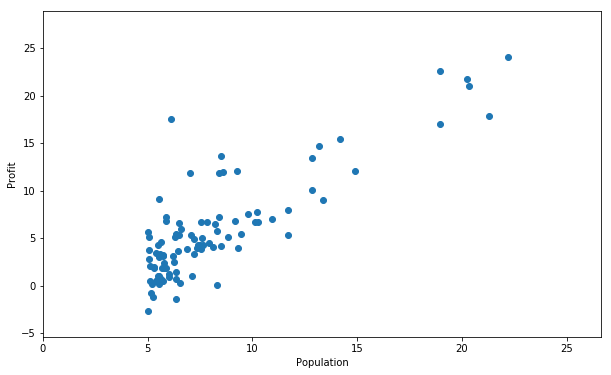

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data.population, data.profit)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_ylim(2*np.min(data.profit), 1.2*np.max(data.profit))
ax.set_xlim(0, 1.2*np.max(data.population))

The pandas DataFrame has built in plotting methods, which are extremely useful for plotting subsets of the data set.  For more information see the [pandas plotting documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html).

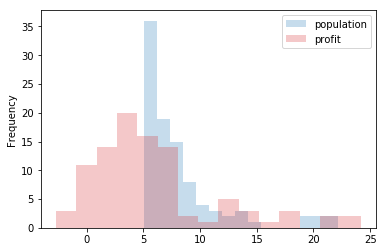

In [8]:
data.population.plot(kind='hist',bins=15, alpha=0.25, color=cp[0])
data.profit.plot(kind='hist',bins=15, alpha=0.25, color=cp[3])
plt.legend()

The two variables have quite different distributions. Examining the distributions is often useful because it can provide insight on a physical reason or mechanism for the origin of the data. But in this case, the distributions provide no information on the relationship between population and profit.

It's clear from the EDA that there is a dependency between profit and population, and that a linear fit (regression) may be a good approximation if we want to predict future data points. 

***

<a id="gd"></a>
# Linear Regression The "Hard" Way: Gradient Descent

Let's implement simple linear regresssion using gradient descent by writing our own fucntions.


In [9]:
# Gradient descent in linear regression doesn't actually require the cost function be calculated.
# However, it's certainly useful to calculate and keep track of the cost/loss for the parameters.
# Here I implement ordinary least squares cost function (without regression)

def Cost(X, y, theta):
    """ Calculates the ordinary least squares difference between the model hypothesis and the target variable
    input
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable
    theta: a 1 x n matrix; the model parameters
    
    output
    cost: the sum of the ordinary least squares over all the data
    """
    
    M=len(X) #number of data points
    cost = np.sum( np.power(((X * theta.T) - y), 2) ) / (2*M)
    return cost
#The cost function is vectorized for faster implementation

When we do linear regression manually, we need to add the bias term (a column of ones in $X$). Here we have to do it manually, but later we'll find that sklearn implements the bias automatically.

In [10]:
X = np.matrix(data.population.astype(float)).T # convert the DataFrame into a numpy matrix
X = np.insert(X, 0, np.ones(len(X)), axis=1)   # add the bias column

y = np.matrix(data.profit.astype(float)).T     # convert the DataFrame into a numpy matrix

X.shape, y.shape

((97, 2), (97, 1))

Because the cost function is vectorized, it's important to keep track of the $X$, $y$, and $\theta$ matrix shapes! <br>
- $X$ is $m \times n$
- $y$ is $m \times 1$
- $\theta$ is $1 \times n$

For this example, $X$ is $97\times2$: the populations plus the bias term.

Linear regression is (by definition) a linear model where the hypothesis is given by $\theta^T X$. We need to find the parameters Theta which provide the best linear fit to the data. In other words, We need to find the theta values which minimize the cost.

In [11]:
#Initialize theta
theta = np.matrix(np.zeros(X.shape[1]))
theta.shape

(1, 2)

In [12]:
# This gives us the right dimensions when we multiply X*theta.T in the cost function
# Let's check that the cost function works
Cost(X, y, theta)

32.072733877455676

Let's pause here for a second. If we look at the bottom of page 6 of the `ex1.pdf` from Andrew Ng's coursera handout, we can see that the expected cost is 32.07 for $\theta$ = [[0,0]]. 

To actually do gradient descent, we don't need the cost function, but it's useful for keeping track of how gradient descent is performing. Let's now implement gradient descent (without regularization). 

In [13]:
# Gradient Descent function 
def Grad_Descent(theta, X, y, learning_rate, iterations):
    """ Implements gradient descent and returns the optimal theta parameters 
        and the running cost
        
    input
    theta: a 1 x n matrix; the model parameters
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable
    learning_rate: float; the gradient descent step size
    iterations: int; number of iterations to complete
    
    
    output: (theta, cost) tuple
    theta: a 1 x n matrix; the optimal model parameters as determined by gradient descent
    cost: a numpy array; the running cost calculated during each iteration of gradient descent
    """
    
    M=len(X) # m
    parameters = int(theta.shape[1]) # n
    
    #initialize
    theta_update = np.matrix(np.zeros(theta.shape))
    cost = np.zeros(iterations)
    
    for i in range(iterations):
        cost[i] = Cost(X, y, theta)
        
        error = (X * theta.T) - y
        
        for j in range(parameters):
            term = np.multiply(error, X[:,j])
            theta_update[0,j] = theta[0,j] - ((learning_rate / M) * np.sum(term))
            
        theta = theta_update

        
    return theta, cost

In [14]:
# Pre-set the hyperparameters of the gradient descent model
iterations = 200000
lr=0.001

#call gradient descent to obtain the best fit parameters
theta_fit, cost = Grad_Descent(theta, X, y, lr, iterations)

In [15]:
print(' ')
print('Intercept: {:.4}; Slope: {:.4}, Cost: {:.4}'.format(theta_fit[0,0], theta_fit[0,1], cost[-1]))
print(' ')

 
Intercept: -3.896; Slope: 1.193, Cost: 4.477
 


Text(0, 0.5, 'Cost')

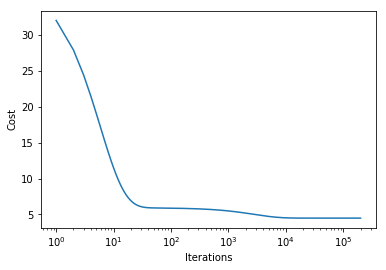

In [16]:
# plot the cost array to see if the gradient descent algorithm is converging

x = range(1,iterations+1)
plt.plot(x,cost)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [17]:
#Let's plot the fit.
x = [0,1.2*np.max(data.population)]
lin_fit = [theta_fit[0,0] + theta_fit[0,1]*i for i in x]

(0, 26.643600000000003)

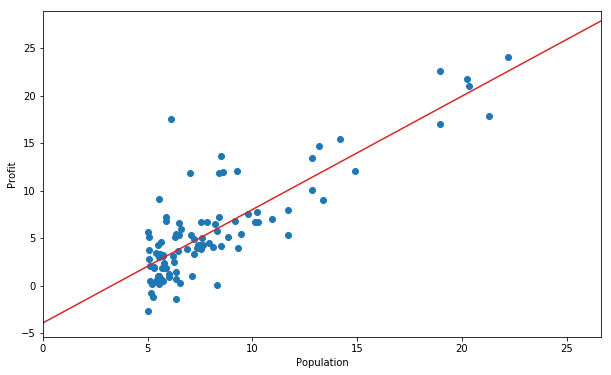

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data.population, data.profit) # plot the data
plt.plot(x, lin_fit, color=cp[3]) # plot the fit
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_ylim(2*np.min(data.profit), 1.2*np.max(data.profit))
ax.set_xlim(0, 1.2*np.max(data.population))

### Looking good!
<a id="viz"></a>
# Visualizing the Cost Function

Text(0.5, 0, 'Slope, theta_1')

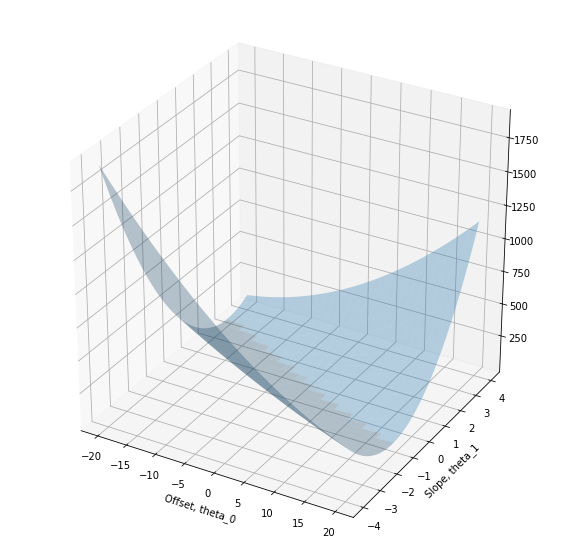

In [19]:
points=200
b_values = np.linspace(-20, 20, num=points)
m_values = np.linspace(-4, 4, num=points)

B, M = np.meshgrid(b_values, m_values)
Z = B[:,:]*0

#theta = np.matrix([B[0,0],M[0,0]])
#Cost(X, y, theta)

for i in range(points):
    for j in range(points):
        theta = np.matrix([B[i,j],M[i,j]])
        Z[i,j] = Cost(X, y, theta)


# Ptot a 3D contour of the cost function
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(B, M, Z, rstride=8, cstride=8, alpha=0.3)
ax.set_xlabel('Offset, theta_0')
ax.set_ylabel('Slope, theta_1')

Text(0, 0.5, 'Slope, theta_1')

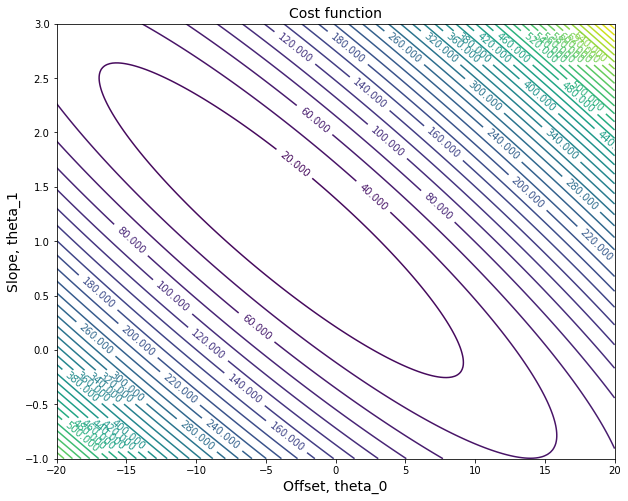

In [20]:
points=200
b_values = np.linspace(-20, 20, num=points)
m_values = np.linspace(-1, 3, num=points)

B, M = np.meshgrid(b_values, m_values)
Z = B[:,:]*0


for i in range(points):
    for j in range(points):
        theta = np.matrix([B[i,j],M[i,j]])
        Z[i,j] = Cost(X, y, theta)


fig, ax = plt.subplots(figsize=(10,8))
CS=ax.contour(B, M, Z, 50, cmap='viridis')
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Cost function', fontsize=14)
ax.set_xlabel('Offset, theta_0', fontsize=14)
ax.set_ylabel('Slope, theta_1', fontsize=14)

### Awesome!

With just a few snippets of code, we've implemented linear regression using gradient descent and looked at the cost function's dependence on the y-intercept and slope of the linear fit.

So far, we haven't explored the impact of the number of iterations and the learning rate. How did I know that 200k iterations and a learning rate of 0.001 would be good hyperparameters? Let's briefly explore the impact of the learning rate on the number of iterations (time) needed to converge a solution.
<a id="lr"></a>
# Learning About Learning Rates

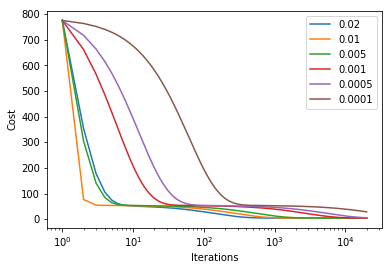

In [21]:
iters = 20000
lrs=[0.02,0.01,0.005,0.001,0.0005,0.0001]
x = range(1,iters+1)
    
for lr in lrs:
    g, cost = Grad_Descent(theta, X, y, lr, iters)

    plt.plot(x,cost, label='{}'.format(lr))
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()

If you use too small of a learning rate, it doesn't converge quickly. You have to try a few to get a feel for a good learning rate. This is a drawback of gradient descent. 

As written, the function doesn't autoscale the learning rate to ensure convergence. You have to carefully guess ahead of time an efficient learning rate for the problem. 

What happens if we try to be cheeky and choose a "high" learning rate? (Note: "high" is relative since the learning rate is really just a scale factor that determines how fast you move along the gradient. It determines the change in amplitude of ALL the model parameters.)

In [22]:
lr=0.1  # a high learning rate
iters=1000
g, cost = Grad_Descent(theta, X, y, lr, iters)
g, cost[iters-1]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in power
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


(matrix([[nan, nan]]), nan)

If the learning rate is too high, then gradient descent does not converge on a solution. Instead of converging, the update model parameter is too large for the cost parabola and bounces around. This is described in some detail in Andrew Ng's course.

---

Gradient descent remains one of the fundamental approaches for finding the solutions to a linear model and can scale well to large data sets.   However, we'll see shortly that there are programatically easier ways to implement logistic regression in python. 

***

<a id="ne"></a>

# Linear Regression The "Normal" Way

Instead of using gradient descent, we can use the vectorized normal equation.<br>
Here, $X$ and $y$ are the same as above for gradient descent.

In [51]:
def lin_reg_linalg(X, y):
    """ Calculates the optimal linear model parameters based on the normal equation
    input
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable
    
    output
    theta: a 1 x n matrix; the optimal model parameters as determined by gradient descent
    """

    XTX = np.dot(X.T,X)
    XTX_inv = np.linalg.pinv(XTX)
    XTX_invXT = np.dot(XTX_inv,X.T)
    
    theta = np.dot(XTX_invXT,y)

    return theta

In [24]:
theta_fit = lin_reg_linalg(X, y)
print(' ')
print('Intercept: {:.4}; Slope: {:.4}'.format(theta_fit[0,0], theta_fit[1,0]))
print(' ')

 
Intercept: -3.896; Slope: 1.193
 


The normal equation provides the same intercept and slope for the best fit line.

### Let's compare the computation times of these two approaches.

In [25]:
%%timeit -n 1000
lin_reg_linalg(X, y)

77.2 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
%%timeit -n 10
Grad_Descent(theta, X, y, 0.01, 1000)

97.7 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


With such little data and only one feature, gradient descent is much slower than the normal equation approach.  However this is not necessarily true when there is a huge amount of data and features. In that case the matrix multiplication and inversions become computationally expensive. For very large data sets with many features, optimized versions gradient descent (i.e. batch) performs better.


<a id="sk"></a>
# Linear Regression The Easy Way: scikit-learn linear models

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# the sklearn API lets you create an instance, from which you can then fit the data using the methods.
LinearRegression?

__LinearRegression implements ordinary least squares regression using scipy.linalg.lstsq (without regularization).__

For this example, we are not going to worry about test/train splits or cross validation, although in general, these are good practices when exploring a model and it's performance in terms of predicting future data.

In [28]:
X = np.matrix(data.population.astype(float)).T
y = np.matrix(data.profit.astype(float)).T

X.shape, y.shape
# Use matrices rather than pandas data frames for sklearn
# Column information/order can be lost when using sklearn on dataframes

((97, 1), (97, 1))

In [29]:
linreg = LinearRegression('fit_intercept=True', 'normalize=False') # create the linear regression object
linreg.fit(X, y) # fit the complete data set

LinearRegression(copy_X=True, fit_intercept='fit_intercept=True', n_jobs=None,
         normalize='normalize=False')

That's it! Our model is trained! As we'll see in a second the optimal parameters are contained within our `linreg` object.

In [30]:
print(' ')
print('Intercept: {:.4}; Slope: {:.4}'.format(linreg.intercept_[0], linreg.coef_[0,0]))
print(' ')

 
Intercept: -3.896; Slope: 1.193
 


__Great!__ But what about goodness of fit? Let's look at a few statistical measures.

In [31]:
mae = mean_absolute_error(y, linreg.predict(X))
mse = mean_squared_error(y, linreg.predict(X))
r2 = r2_score(y, linreg.predict(X))

print(' ')
print('Mean Absolute Error: {:.4}; Mean Squared Error: {:.4}; R^2 score: {:.4}'.format(mae, mse, r2))
print(' ')

 
Mean Absolute Error: 2.194; Mean Squared Error: 8.954; R^2 score: 0.702
 


But how does sklearn compare in computational time?

In [32]:
%%timeit -n 100
linreg = LinearRegression('fit_intercept=True', 'normalize=False') # create the linear regression object
linreg.fit(X, y) # fit the complete data set

529 µs ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Not bad, sklearn is significantly faster than my home-made version of gradient descent, but not as fast as my implementation of the normal equation. At this point it's an open question whether or not sklearn's LinearRegression package is better than the normal equation for larger data sets with more features.

Text(0, 0.5, 'Profit')

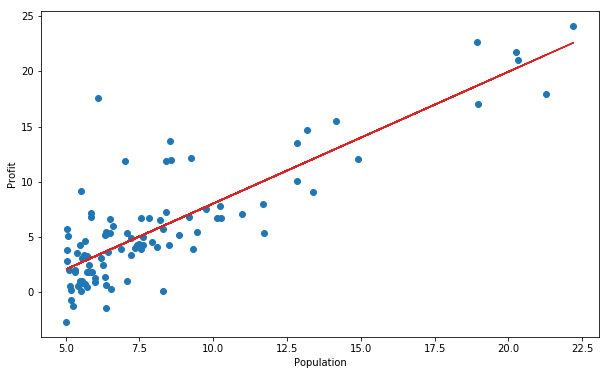

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
ax= plt.scatter(data.population, data.profit) # plot the data
ax= plt.plot(X, linreg.predict(X), color=cp[3]) # plot the fit
plt.xlabel('Population')
plt.ylabel('Profit')

<a id="sns"></a>
# Visualizing Linear Regression With Searborn's regplot

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 26.643600000000003)

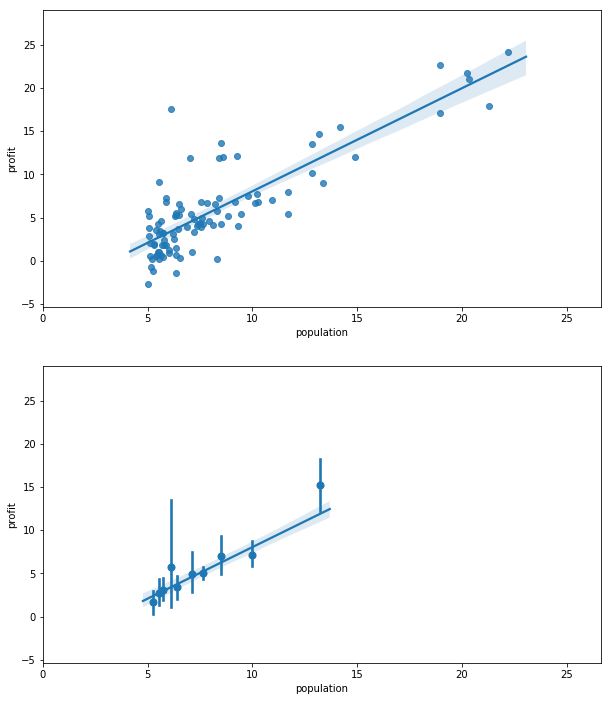

In [34]:
#The quickest way: seaborn regplot

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (10,12))
ax1 = sns.regplot(data.population, data.profit, ax=ax1, color=cp[0])
ax2 = sns.regplot(data.population, data.profit, x_bins=10, ax=ax2, color=cp[0])
ax1.set_ylim(2*np.min(data.profit), 1.2*np.max(data.profit))
ax1.set_xlim(0, 1.2*np.max(data.population))
ax2.set_ylim(2*np.min(data.profit), 1.2*np.max(data.profit))
ax2.set_xlim(0, 1.2*np.max(data.population))
# for data sets with >thousands of data points, it can be very difficult to 
# visualize trends in the raw data. Use binning to reduce data density and ease visualization. 

While seaborn regplot lets you easily see the linear relationship and confidence interval, it doesn't let you pull out the fit parameters.  So this is useless in terms of extracting parameters, but highly useful for quick identifications of linear relationships or guides to the eye.
<a id="Part2"></a>
# Part 2 - Multivariate Linear Regression

Prompt:<br>
Implement linear regression with multiple variables to predict the prices of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.<br>
The file `ex1data2.txt` contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price of the house.

<a id="eda2"></a>
# Exploratory Data Analysis

In [35]:
#Load the data into a pandas DataFrame
data = pd.read_csv('ex1/ex1data2.txt', header=None, names=['size', 'bedrooms', 'price'])
data.head()

,size,bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 3 columns):
size        47 non-null int64
bedrooms    47 non-null int64
price       47 non-null int64
dtypes: int64(3)
memory usage: 1.2 KB


In [37]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
size,47.0,2000.680851,794.702354,852.0,1432.0,1888.0,2269.0,4478.0
bedrooms,47.0,3.170213,0.760982,1.0,3.0,3.0,4.0,5.0
price,47.0,340412.659574,125039.899586,169900.0,249900.0,299900.0,384450.0,699900.0


In [38]:
data.corr()

,size,bedrooms,price
size,1.000000,0.559967,0.854988
bedrooms,0.559967,1.000000,0.442261
price,0.854988,0.442261,1.000000


Seaborn's pairplot offers a super convenient way to plot both the scatter plots between variables as well as the histograms for each individual variable


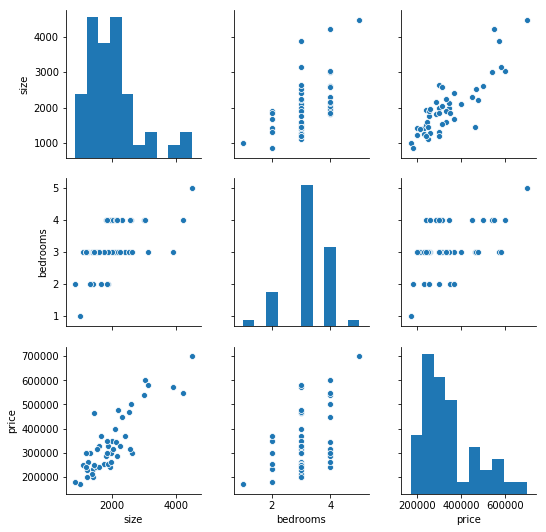

In [39]:
sns.pairplot(data)

From the EDA we can see that the two feature variables are on very, very different scales. We will need to normalize these features in order to run multivariate linear regression with gradient descent. 
<a id="FN"></a>
# Feature Normalization

There are a variety of ways to normalize features. Often it depends on the kind of data you are working with. Since we only have two features for this example problem, it's easy to do this manually using a "standard" normaliation approach in which the mean is subtracted from the data and normalized according to the variance. Alternatively, we could use scaling functions that come with the sklearn API. There are a great many kinds of scaling options available. For more information see [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).

In [40]:
# Select the features that will predict price
X = data[['size','bedrooms']] 

# Normalize according to the mean. Analagous to sklearn.preprocessing.StandardScaler
X['size_norm'] = (data['size'] - data['size'].mean())/ data['size'].std()
X['bedrooms_norm'] = (data.bedrooms - data.bedrooms.mean()) / data.bedrooms.std()

# convert the DataFrame into a numpy matrix
X = np.matrix(X[['size_norm','bedrooms_norm']])
# add the bias column
X = np.insert(X, 0, np.ones(len(X)), axis=1)

# convert the target variables from the DataFrame into a numpy matrix
y = np.matrix(data.price.astype(float)).T 

#Initialize theta
theta = np.matrix(np.zeros(X.shape[1]))

X.shape, y.shape, theta.shape

((47, 3), (47, 1), (1, 3))

Again, keep carefuly track of the matrix shapes!

Note that I did NOT scale the $y$ target variables. You certainly could normalize the $y$ values. But afterwards, to predict new prices, you would have to scale down the number of bedrooms and house size, and then scale the result of the model to put it back onto the original pricing scale. This is just overkill. Instead, we only scale the features, leaving $y$ alone, and let the $\theta$ values absorb this scaling between the normalized features and the target price.
<a id="gd2"></a>
# Implementing Gradient Descent

The functions we have already written for gradient descent and calculating the cost are already written in a nice vectorized form and we should simply be able to use them here.

In [41]:
Cost(X,y,theta)

65591548106.45744

In [42]:
# Pre-set the hyperparameters of the gradient descent model
iterations = 10000
lr=0.01

#call gradient descent to obtain the best fit parameters
theta_fit, cost = Grad_Descent(theta, X, y, lr, iterations)

In [43]:
theta_fit

matrix([[340412.65957447, 110631.05027884,  -6649.47427082]])

In [44]:
print(' ')
print('Bias Term: {:.4}; Slope Size: {:.4}, Slope Bedrooms: {:.4}; Cost: {:.4}'.format(\
                            theta_fit[0,0], theta_fit[0,1], theta_fit[0,2], cost[-1]))
print(' ')

 
Bias Term: 3.404e+05; Slope Size: 1.106e+05, Slope Bedrooms: -6.649e+03; Cost: 2.043e+09
 


Text(0, 0.5, 'Cost')

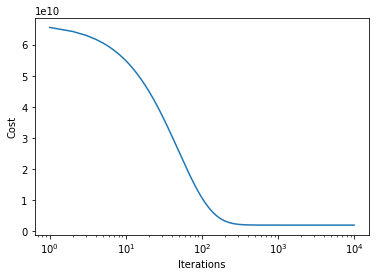

In [45]:
# plot the cost array to see if the gradient descent algorithm is converging

x = range(1,iterations+1)
plt.plot(x,cost)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost')

<a id="ne2"></a>
# Multivariate Linear Regression By The Normal Equation

As discussed briefly in `ex1.pdf`, there is no need to normalize the features when using the normal equation. 

In [46]:
# convert the features from the DataFrame into a numpy matrix
X = np.matrix(data.iloc[:,:-1])
# add the bias column
X = np.insert(X, 0, np.ones(len(X)), axis=1)

# convert the target variables from the DataFrame into a numpy matrix
y = np.matrix(data.price.astype(float)).T 
X.shape, y.shape

((47, 3), (47, 1))

In [47]:
theta_fit = lin_reg_linalg(X, y)

In [48]:
print(' ')
print('Bias Term: {:.4}; Slope Size: {:.4}, Slope Bedrooms: {:.4}; Cost: {:.4}'.format(\
                            theta_fit[0,0], theta_fit[1,0], theta_fit[2,0], cost[-1]))
print(' ')

 
Bias Term: 8.96e+04; Slope Size: 139.2, Slope Bedrooms: -8.738e+03; Cost: 2.043e+09
 


The optimal model parameters are different (from gradient descent) because the features were not normalized.
<a id="sk2"></a>
# Multivariate Linear Regression with sklearn

In [49]:
# convert the features from the DataFrame into a numpy matrix
X = np.matrix(data.iloc[:,:-1])
# convert the target variables from the DataFrame into a numpy matrix
y = np.matrix(data.price.astype(float)).T 

linreg = LinearRegression('fit_intercept=True', 'normalize=False') # create the linear regression object
linreg.fit(X, y) # fit the complete data set

LinearRegression(copy_X=True, fit_intercept='fit_intercept=True', n_jobs=None,
         normalize='normalize=False')

In [50]:
print(' ')
print('Intercept: {:.4}; Slope Size: {:.4}, Slope Bedrooms: {:.4}'.format(\
                                            linreg.intercept_[0], linreg.coef_[0,0], linreg.coef_[0,1]))
print(' ')

 
Intercept: 8.96e+04; Slope Size: 139.2, Slope Bedrooms: -8.738e+03
 


While normalizing your features is often a good idea, in this case sklearn had no problem finding the optimal model parameters from the raw data. A beautiful thing about sklearn is that the machine learning algorithms are often set-up such that the default hyperparameters work pretty well for the majority of problems you will run into. Not always, but in this simple example, the default parameters give a good result.